## Анализ для магазина «Golden Light VIP Elite»

### Цели и задачи исследования:

1. Какие действия отдела продаж оказывают позитивное влияние на показатели продаж?
2. Какие действия не приносят видимого эффекта?
3. Какая линейная модель позволит спрогнозировать продажи в каком-либо месяце?

In [1]:
# Импортируем библиотеки, необходимые для работы
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot 
from statsmodels.stats.stattools import durbin_watson

In [2]:
# Загрузим данные.
light_data = pd.read_csv('lights_sales_data.csv')
light_data.head()

,month_number,TV,Radio,Newspapers,Surveys,total_marketing_spendings,"total_marketing_spendings, $",days_in_month,days_of_sales,sales
0,1,230.1,37.8,69.2,9.2,337.1,5.170245,29,12,45.2
1,2,44.5,39.3,45.1,24.9,128.9,1.976994,30,17,38.1
2,3,17.2,45.9,69.3,10.6,132.4,2.030675,31,9,36.7
3,4,151.5,41.3,58.5,30.0,251.3,3.854294,30,17,41.0
4,5,180.8,10.8,58.4,13.2,250.0,3.834356,31,2,37.6


Проверим данные на мультиколлинеарность (линейную зависимость переменных друг от друга). Для этого составим матрицу корреляций. Из матрицы мы исключим столбец 'sales' (т.к. эту величину мы будем прогнозировать) а также 'month_number' (фактически это просто номер наблюдения):

In [3]:
light_data.loc[:, [x for x in light_data.columns if x != 'month_number' and x != 'sales']].corr()

,TV,Radio,Newspapers,Surveys,total_marketing_spendings,"total_marketing_spendings, $",days_in_month,days_of_sales
TV,1.000000,0.054809,0.056648,0.007348,0.945330,0.945330,0.012663,0.171939
Radio,0.054809,1.000000,0.354104,0.061084,0.293211,0.293211,0.111377,0.048575
Newspapers,0.056648,0.354104,1.000000,-0.043030,0.343059,0.343059,0.060290,-0.033053
Surveys,0.007348,0.061084,-0.043030,1.000000,0.006459,0.006459,0.109435,0.068414
total_marketing_spendings,0.945330,0.293211,0.343059,0.006459,1.000000,1.000000,0.043596,0.158768
"total_marketing_spendings, $",0.945330,0.293211,0.343059,0.006459,1.000000,1.000000,0.043596,0.158768
days_in_month,0.012663,0.111377,0.060290,0.109435,0.043596,0.043596,1.000000,0.233911
days_of_sales,0.171939,0.048575,-0.033053,0.068414,0.158768,0.158768,0.233911,1.000000


Построим тепловую карту матрицы корреляции, которая покажет данные более наглядно чем таблица

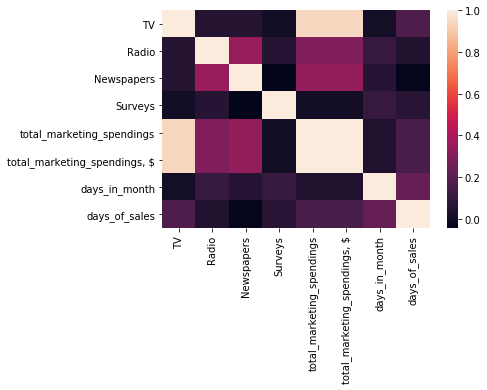

In [4]:
sns.heatmap(light_data.loc[:, [x for x in light_data.columns if x != 'month_number' and x != 'sales']].corr())

Мы видим что переменные ***Radio***, ***TV***, ***Newspapers*** скоррелированы с переменной ***total_marketing_spendings*** поэтому можно предположить что эти три параметра есть сумма ***total_marketing_spendings***. Проверим это предположение:

In [5]:
pd.DataFrame([light_data.loc[:, ['Radio', 'TV', 'Newspapers']].sum(axis=1), light_data.total_marketing_spendings]).T.corr()

,Unnamed 0,total_marketing_spendings
Unnamed 0,1.0,1.0
total_marketing_spendings,1.0,1.0


Как мы видим, параметры ***Radio***, ***TV***, ***Newspapers*** в сумме дают параметр ***total_marketing_spendings***. Поэтому мы можем удалить этот параметр,  оставив только более низкоуровневые параметры, чтобы мы могли отследить их влияние на результат. <br>
Параметр ***total_marketing_spendings, \$***, как мы видим из названия, это тот же параметр ***total_marketing_spendings*** но выраженный в другой валюте (в данном случае это доллар США). Поэтому его также можно исключить.

In [6]:
light_data = light_data.loc[:, [x for x in light_data.columns if x != 'total_marketing_spendings' and x != 'total_marketing_spendings, $']]

Построим визуализации (графики) чтобы посмотреть наглядно какие параметры коррелируют с продажами. Используем одномерную линейную регрессию чтобы посмотреть, как тот или иной параметр влияет на продажи:

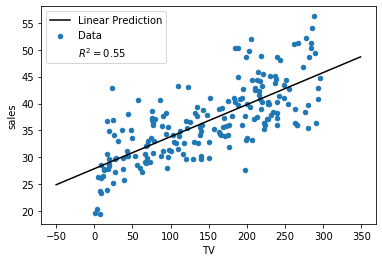

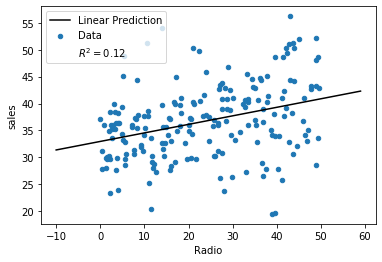

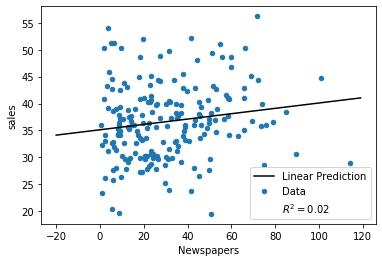

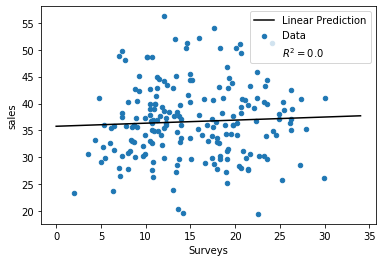

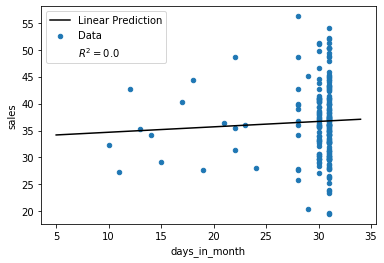

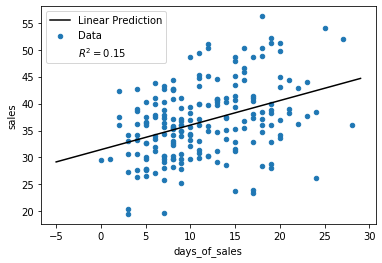

In [7]:
for col in light_data.iloc[:, 1:-1].columns:
    ax = plt.subplot()
    light_data.plot(x = col, y = 'sales', kind = 'scatter', ax = ax, label = 'Data')
    model = LinearRegression()
    model.fit(light_data.loc[:, [col]] #используем такой синтаксис, так как на вход должна подаваться линейная модель
              , light_data.sales)
    r_sq = model.score(light_data.loc[:, [col]], light_data.sales)
    ax.plot(list(range(int(ax.get_xticks()[0]), int(ax.get_xticks()[-1]))),
            [model.intercept_ + model.coef_*x for x in list(range(int(ax.get_xticks()[0]), int(ax.get_xticks()[-1])))]
            , label = 'Linear Prediction', color = 'black')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(mpatches.Patch(color='none', label='$R^2 = ' + str(round(r_sq, 2)) + '$'))
    ax.legend(handles = handles)
    plt.show()

Мы построили графики и для каждого параметра посчитали коэффициент детерминации. Чем больше значение данного коэффициента, тем большую часть дисперсии объясняет параметр.

Как видно, параметр ***TV*** объясняет 55% дисперсии, и следовательно его необходимо использовать для построения модели. Также для построения модели мы будем использовать параметры
- ***Radio*** (объясняет 12% дисперсии), 
- ***Newspapers*** (объясняет 2% дисперсии) 
- ***days_of_sales*** (объясняет 15% дисперсии).

Параметры которые нам не стоит использовать при построении модели (потому что они не объясняют дисперсию в данных):

- ***Surveys***;
- ***days_in_month***.

## Построение многомерной регрессии

### Расчет параметров регрессии

Итак, мы определили 4 параметра потенциально влияющие на продажи. Рассчитаем параметры линейной регрессии, для этого используем функцию OLS из пакете statsmodels

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     113.6
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           8.14e-50
Time:                        16:49:16   Log-Likelihood:                -549.52
No. Observations:                 200   AIC:                             1109.
Df Residuals:                     195   BIC:                             1126.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            21.8616      0.843     25.921

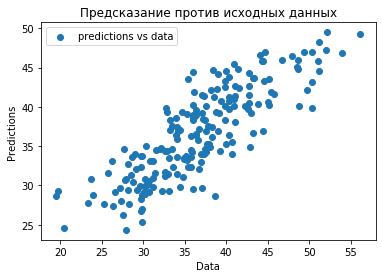

In [8]:
X = sm.add_constant(light_data.loc[:, ['TV', 'Radio', 'Newspapers', 'days_of_sales']])
 
model = sm.OLS(light_data.sales, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)
plt.scatter(light_data.sales, predictions, label = 'predictions vs data')
plt.xlabel('Data')
plt.ylabel('Predictions')
plt.title('Предсказание против исходных данных')
plt.legend()
plt.show()

### Анализ результатов

Проанализируем результаты:
1. **R-squared**, коэффициент детерминации, который показывает, какую долю дисперсии мы можем объяснить нашей моделью. В нашем случае его значение составляет 70%.
2. **F-statistic** Используется для оценки статистической значимости модели регрессии в целом, является соотношением объяснимой дисперсии, к необъяснимой. Если модель линейной регрессии построена удачно, то она объясняет значительную часть дисперсии, оставляя в знаменателе малую часть. **Чем больше значение параметра — тем лучше**.
3. **Prob (F-statistic)**: 8.14<sup>−50</sup>. Полученное высокое значение говорит нам о вероятности того, что модель описывает данные статистически значимо.
4. **Статистика Дарбина-Ватсона** показывающая, насколько в переменных присутствуют автокорреляции (взаимосвязи между последовательностью величин одного ряда, взятыми со сдвигом по времени/измерению). Эта статистика может принимать значения от 0 до 4. При значении, близком к двойке, автокорреляций не наблюдается. В нашем случае значение составляет 2.287.
5. **P>|t| (p value)** этот показатель показывает вероятность истинности нулевой гипотезы, которая гласит, что независимые переменные не объясняют динамику зависимой переменной. Если значение p-value ниже порогового уровня (0.05), то нулевая гипотеза ложная и показатель можно использовать при построении уравнения регрессии. Для показателя ***Newspapers*** значение p-value составляет 0.522, поэтому данный показатель следует исключить из финальной модели


### Проверяем ошибки

Проверим, что ошибка измерения случайна и имеет постоянный разброс. Для этого используем **QQ-plot**:

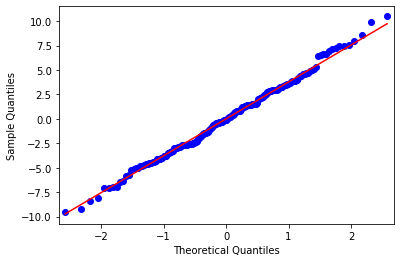

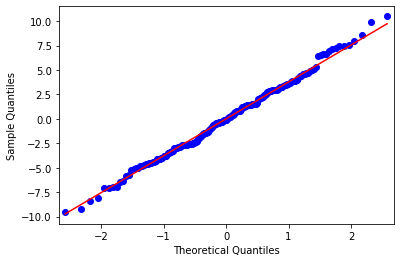

In [9]:
qqplot(model.resid, line = 's')

Как мы видим из QQ-plot, распределение ошибок нормальное, то есть имеет постоянный разброс и является случайной величиной, распределённой нормально.<br><br>
Проверим также **ошибки на корреляцию со значимыми параметрами модели**:

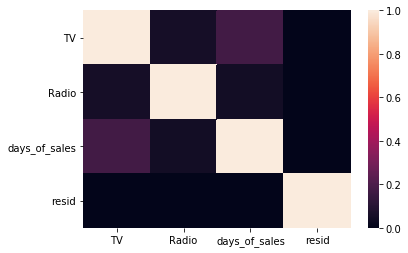

In [10]:
light_data['resid'] = model.resid
sns.heatmap(light_data.loc[:, ['TV', 'Radio', 'days_of_sales', 'resid']].corr());

Как мы видим, ошибки не коррелируют с параметрами модели, а значит, применение линейной модели легально.

### Коэффициенты линейной регрессии и построение модели

Итоговая линейная модель предсказания продаж будет выглядеть следующим образом:

**sales = 0.05∗TV + 0.13∗Radio + 0.3∗days_of_sales + 21.86**

## Выводы:

1. Без дополнительных вложений в продвижение продаж компания в среднем продает на 21.86.
2. Значительный вклад в продажи вносят вложения в рекламу по телевидению, в рекламу на радио, а также количество дней работы распродаж. 
3. Не стоит вкладывать в рекламу в газетах, а также в исследования рынка. Данные показатели не приносят значимого увеличения объема продаж. 
4. Количество дней в месяце, в которые работала компания также не оказывают влияния на объем продаж.


### Рекомендации по увеличению объема продаж:

1. Наибольший вклад в увеличение объема продаж вносят распродажи, поэтому рекомендуется увеличить длительность работы распродаж. Также можно попробовать чаще проводить распродажи, т.к. их влияние наиболее сильное;
2. Можно попробовать увеличить количество радиостанций и телевизионных каналов, которые транслируют нашу рекламу, т.к. прослеживается четкая взаимосвязь между размещением рекламы и продажами.
3. Реклама на радио работает лучше, чем реклама на телевидение, поэтому рекомендуется пересмотреть подход к рекламе на телевидение, например возможно изменить каналы, транслирующие ролик, или переработать сам ролик и т.п.
4. Следует значительно сократить или даже полностью ликвидировать расходы на рекламу в газетах и расходы на исследования рынка, т.к. данные показатели существенно не влияют на увеличение объема продаж.  